In [202]:
from os import listdir, path, errno, makedirs
from shutil import copyfile

import re
from PIL import Image, ImageStat

import numpy as np
import pandas as pd
from scipy import stats
import scipy.fftpack
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.misc
%matplotlib inline

In [203]:
def normalize(img, M0=250, VAR0=100):
    I = img.copy()
    M = I.sum() / I.shape[0] / I.shape[1]
    VAR = ((I - M) ** 2).sum() / I.shape[0] / I.shape[1]
    G = -np.sqrt(VAR0 * (I - M) ** 2 / VAR)
    G[I > M] *= -1
    G += M0
    return G

In [204]:
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi/32):
        kern = cv.getGaborKernel((ksize, ksize), 5, theta, 10.0,1, 0, ktype=cv.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

In [205]:
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv.filter2D(img, cv.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [206]:
def func(img, n_scale,isFiltered):
    res= img.copy()
    if(isFiltered):
        filters = build_filters()
        res = process(normalize(img), filters)
    #     res = util.process((img)/img.std(), filters)
      #  mean = np.mean(res) * 1
    #     for i in range(res.shape[0]):
    #         for j in range(res.shape[1]):
    #             if (res[i][j] < mean):
    #                 res[i][j] = 0
    #             else:
    #                 res[i][j] = 255
    res = res.reshape(-1)
    N = res.shape[0] / n_scale
    T = 1.0 / (255 * 2)
    yf = scipy.fftpack.fft(res)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), int(N / 2))
    
    return xf[1:], (2.0 / N * np.abs(yf[:int(N / 2)]))[1:], res

In [231]:
def quick_test(p):
    fig, axes = plt.subplots(2, 3,  figsize=(10, 5))
#     img = cv.imread(p, 0)
#     clr = cv.imread(p)
#     x, y, res = func(img, n_scale)
#     t = clr.reshape((clr.shape[0]*clr.shape[1], 3))
    img = cv.imread(p, 0)
    clr = cv.imread(p)
    x, y, res = func(clr, 1,False)
    t = clr.reshape((clr.shape[0]*clr.shape[1], 3))
#     print(t.std(axis=0), t.mean(axis=0))
#     print(t[:, [0, 2]].mean())
#     print(t[:, [0, 2]].std(axis=0))
#     print(t[:, [0, 2]].std(axis=0),t[:, [0, 2]].std(axis=0).sum())
#     print(t[:, [1, 2]].std(axis=0),t[:, [1, 2]].std(axis=0).sum())
#     print(t[:, [0, 1]].std(axis=0),t[:, [0, 1]].std(axis=0).sum())
    axes[0,0].plot(x,y)
    x, y, res = func(clr, 1,True)
    axes[0,1].plot(x,y)
    x, y, res = func(img, 1,False)
    axes[1,0].plot(x,y)
    x, y, res = func(img, 1,True)
    axes[1,1].plot(x,y)
    axes[1,2].imshow(clr)
    plt.show()

# Observation
If we FFT color no normalization pic middle ages art is unique(Second peak is low)


# imp
แกน x ยาวกว่า ba ( เกิน x = 100 ) และ มีค่า y ช่วงต้น ประมาณ 1 ถึง 2

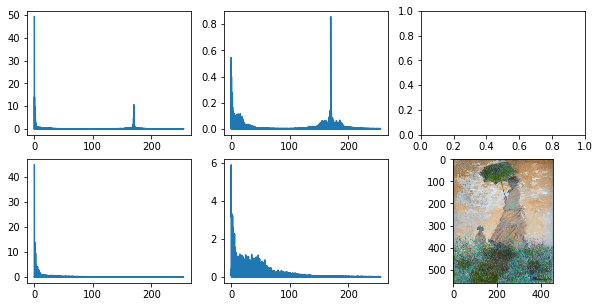

In [232]:
quick_test('/CP/Git_time/TimeSeries_mid/imp/61379-primary-0-740x560.jpg')

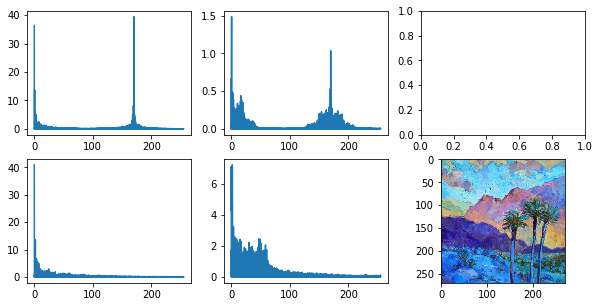

In [233]:
quick_test('/CP/Git_time/TimeSeries_mid/imp/indian-wells-erin-hanson-prints.jpg')

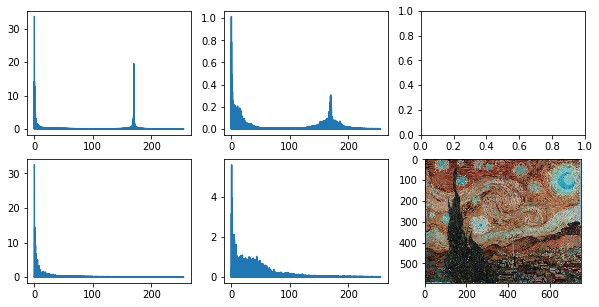

In [234]:
quick_test('/CP/Git_time/TimeSeries_mid/imp/van-gogh-starry-night.jpg')

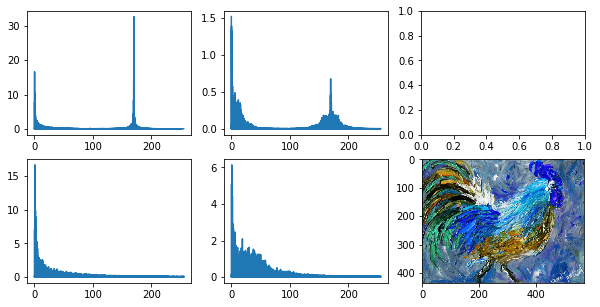

In [235]:
quick_test('/CP/Git_time/TimeSeries_mid/imp/il_570xn-550871926_molt.jpg')

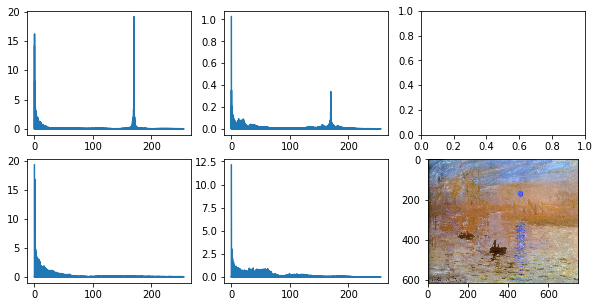

In [236]:
quick_test('/CP/Git_time/TimeSeries_mid/imp/sunrise.jpg')

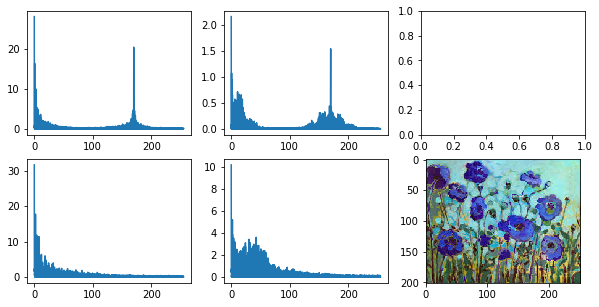

In [237]:
quick_test('/CP/Git_time//TimeSeries_mid/imp/im09.jpg')

# ba
ค่า y 2 ถึง 4 แกน x ตกที่ 50 ถึง 75

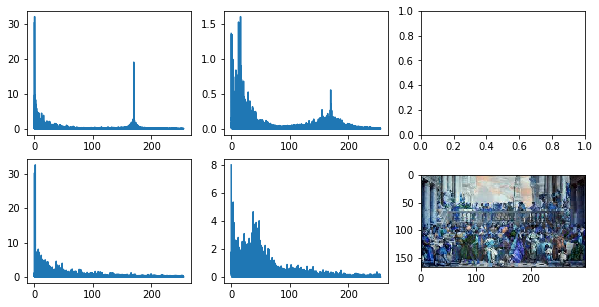

In [238]:
quick_test('/CP/Git_time/TimeSeries_mid/ba/ba01.jpg')

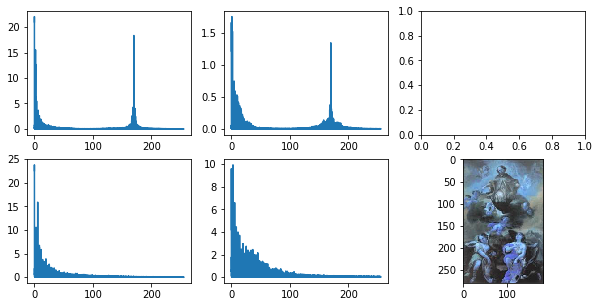

In [239]:
quick_test('/CP/Git_time/TimeSeries_mid/ba/ba05.jpg')

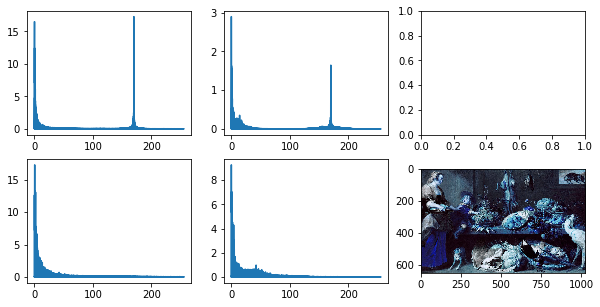

In [240]:
quick_test('/CP/Git_time/TimeSeries_mid/ba/ba02.jpg')

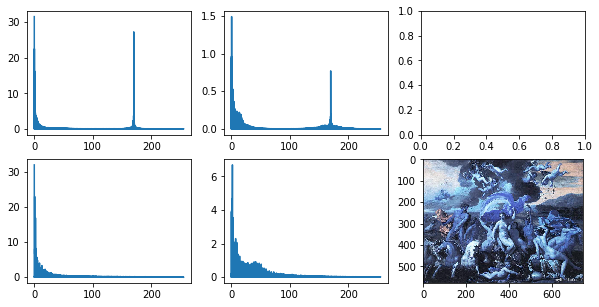

In [241]:
quick_test('/CP/Git_time/TimeSeries_mid/ba/ba07.jpg')

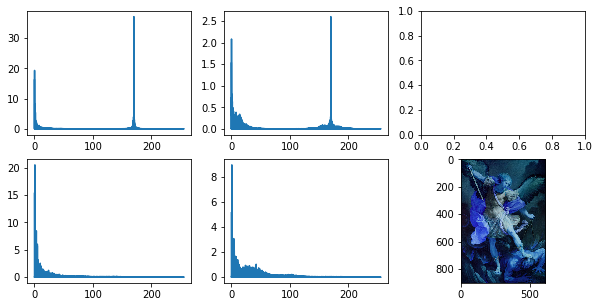

In [242]:
quick_test('/CP/Git_time/TimeSeries_mid/ba/ba06.jpg')

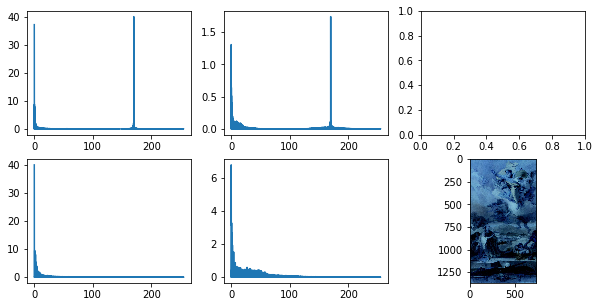

In [243]:
quick_test('/CP/Git_time/TimeSeries_mid/ba/ba09.jpg')

# pop

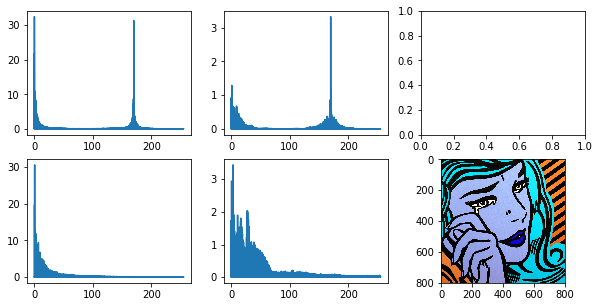

In [244]:
quick_test('/CP/Git_time/TimeSeries_mid/pop/p01.png')

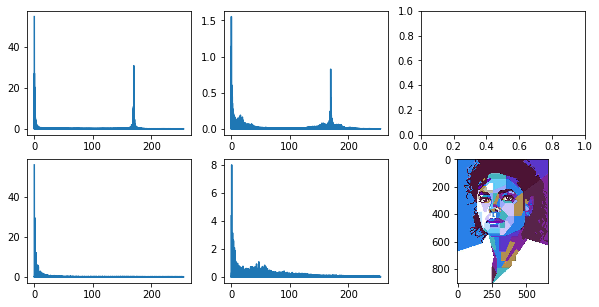

In [245]:
quick_test('/CP/Git_time/TimeSeries_mid/pop/p07.jpg')

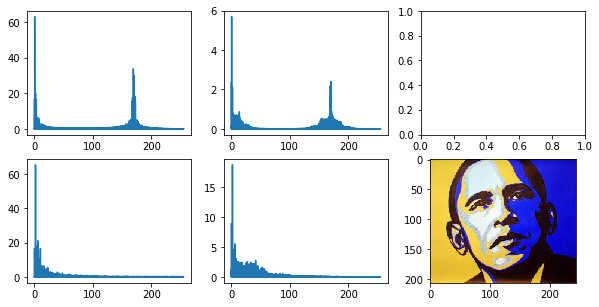

In [246]:
quick_test('/CP/Git_time/TimeSeries_mid/pop/p10.jpg')

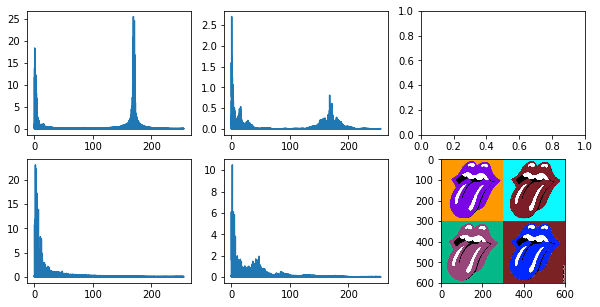

In [247]:
quick_test('/CP/Git_time/TimeSeries_mid/pop/p08.jpg')

# mid

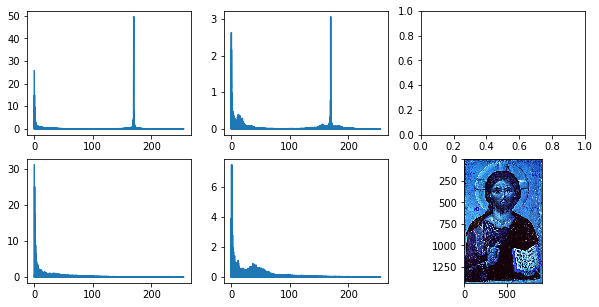

In [248]:
quick_test('/CP/Git_time/TimeSeries_mid/middle/m01.jpg')

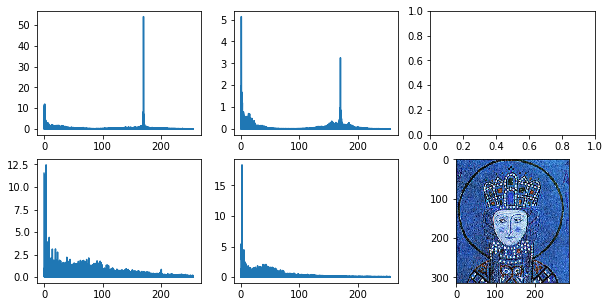

In [249]:
quick_test('/CP/Git_time/TimeSeries_mid/middle/m02.jpg')

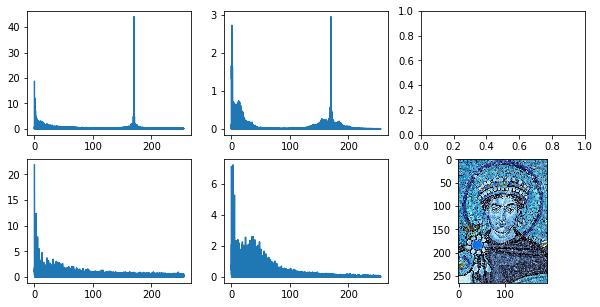

In [250]:
quick_test('/CP/Git_time/TimeSeries_mid/middle/m03.jpg')

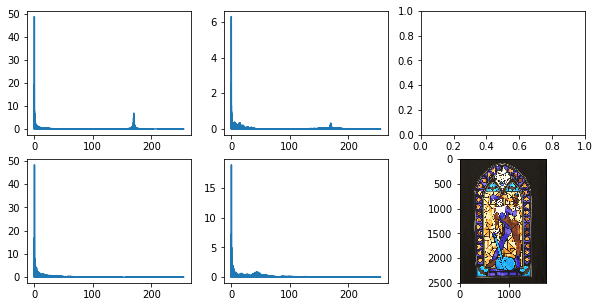

In [251]:
quick_test('/CP/Git_time/TimeSeries_mid/middle/m06.jpg')

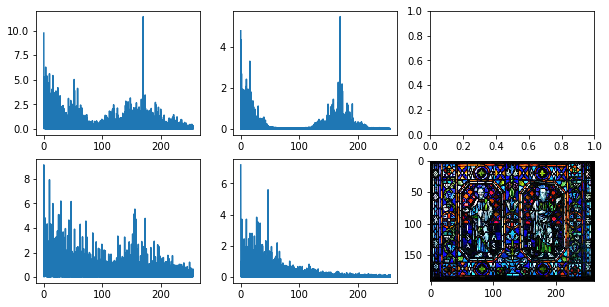

In [252]:
quick_test('/CP/Git_time/TimeSeries_mid/middle/m07.jpg')

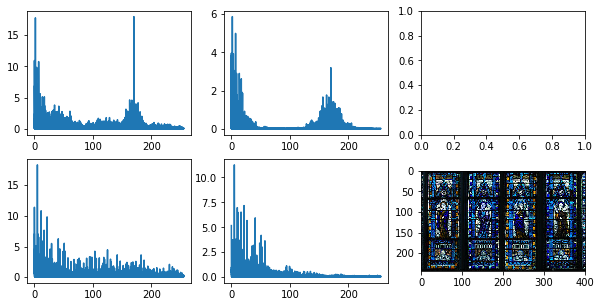

In [253]:
quick_test('/CP/Git_time/TimeSeries_mid/middle/m08.jpg')

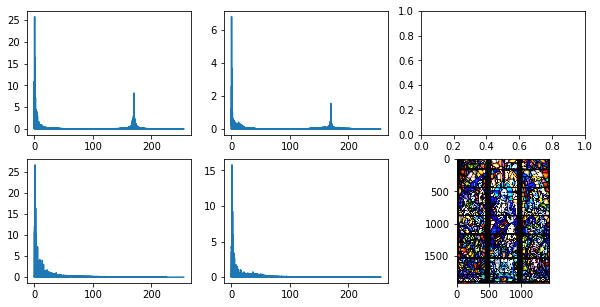

In [254]:
quick_test('/CP/Git_time/TimeSeries_mid/middle/m09.jpg')